# ***Set Parameters to define model etc***

In [1]:
import os
import sys

sys.path.append('../../scripts')
sys.path.append('../../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work

from scipy.io import savemat
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from output_statistics import *
from data_augmentation import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 
import nibabel as nib

#### Model import correct model
from Unet import * #from Naive_CNN_3D_Residual_No_Batch_Norm import *

grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

In [2]:
# AF = 4

# Glx_GT = np.zeros((22,22,21,8))

# for i in range(0,8):
#     Glx_GT[...,i] = nib.load(f'Glx_amp_map_{i}.nii').get_fdata()
    
# np.save(f'Glx_Concentration_AF{AF}.npy',Glx_GT)

# Water_GT = np.zeros((22,22,21,8))

# for i in range(0,8):
#     Water_GT[...,i] = nib.load(f'water_amp_map_{i}.nii').get_fdata()
    
# np.save(f'Water_Concentration_AF{AF}.npy',Water_GT)

# Glc_GT = np.zeros((22,22,21,8))

# for i in range(0,8):
#     Glc_GT[...,i] = nib.load(f'Glc_amp_map_{i}.nii').get_fdata()
    
# np.save(f'Glc_Concentration_AF{AF}.npy',Glc_GT)



In [3]:
water_GT = np.load('Lac_Concentration_GT.npy')
water_AF2 = np.load('Lac_Concentration_AF2.npy')
water_AF4 = np.load('Lac_Concentration_AF4.npy')

In [4]:
### getting into right shape

Water_GT = np.zeros((22,22,21,96,8))
Water_AF2 = np.zeros((22,22,21,96,8))
Water_AF4 = np.zeros((22,22,21,96,8))

for i in range(0,96):
    Water_GT[:,:,:,i,:] = water_GT
    Water_AF2[:,:,:,i,:] = water_AF2
    Water_AF4[:,:,:,i,:] = water_AF4

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


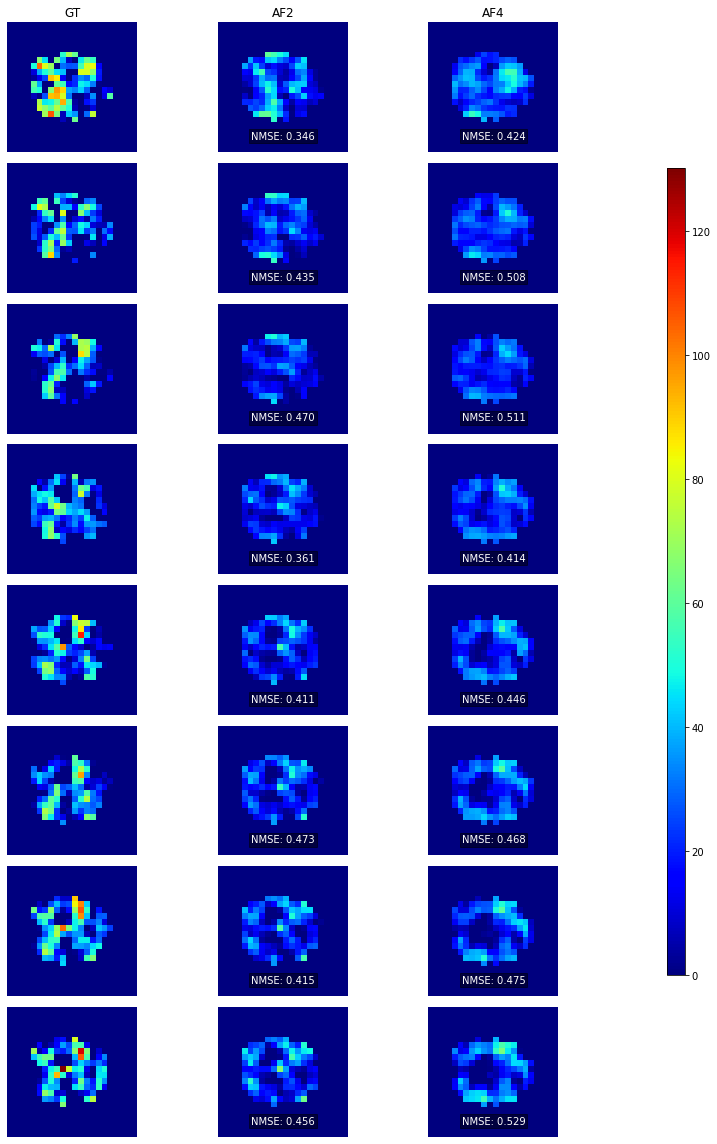

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Fix the z index (choose an index between 0 and 20)
z_index = 15  

# Determine the color scale from water_GT for the fixed z slice across all time indices.
vmin = water_GT[:, :, z_index, :].min()
vmax = water_GT[:, :, z_index, :].max()

# Create a figure with 8 rows (time points) and 3 columns (GT, AF2, AF4)
fig, axes = plt.subplots(8, 3, figsize=(12, 16))

# Choose a colorful colormap
cmap = 'jet'  # Alternatively, you can try 'plasma', 'inferno', or 'viridis'

# Loop over each time index
for t in range(8):
    ax_gt = axes[t, 0]
    ax_af2 = axes[t, 1]
    ax_af4 = axes[t, 2]
    
    # Extract and take the absolute value of the fixed z-slice for each dataset at time t
    gt_slice = np.abs(water_GT[:, :, z_index, t])
    af2_slice = np.abs(water_AF2[:, :, z_index, t])
    af4_slice = np.abs(water_AF4[:, :, z_index, t])
    
    # Plot the images using the common color scale from GT
    im_gt = ax_gt.imshow(gt_slice, vmin=vmin, vmax=vmax, cmap=cmap)
    ax_af2.imshow(af2_slice, vmin=vmin, vmax=vmax, cmap=cmap)
    ax_af4.imshow(af4_slice, vmin=vmin, vmax=vmax, cmap=cmap)
    
    # Compute normalized MSE for AF2 and AF4 with respect to GT for this slice and time t
    nmse_af2 = np.sum((af2_slice - gt_slice)**2) / np.sum(gt_slice**2)
    nmse_af4 = np.sum((af4_slice - gt_slice)**2) / np.sum(gt_slice**2)
    
    # Annotate the computed NMSE on the AF2 and AF4 plots
    ax_af2.text(0.5, 0.1, f'NMSE: {nmse_af2:.3f}', transform=ax_af2.transAxes, 
                color='white', ha='center', fontsize=10,
                bbox=dict(facecolor='black', alpha=0.5, pad=2))
    ax_af4.text(0.5, 0.1, f'NMSE: {nmse_af4:.3f}', transform=ax_af4.transAxes, 
                color='white', ha='center', fontsize=10,
                bbox=dict(facecolor='black', alpha=0.5, pad=2))
    
    # Label each row with its time index on the first column
    ax_gt.set_ylabel(f'Time {t+1}', rotation=0, labelpad=30, va='center')
    
    # Remove axis ticks for a cleaner look
    for ax in [ax_gt, ax_af2, ax_af4]:
        ax.axis('off')

# Set the column titles on the top row
axes[0, 0].set_title('GT')
axes[0, 1].set_title('AF2')
axes[0, 2].set_title('AF4')

# Add one common colorbar. Adjust the figure to leave room on the right.
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
fig.colorbar(im_gt, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.85, 1])

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
../../scripts/output_statistics.py:283: RuntimeWarning: invalid value encountered in double_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


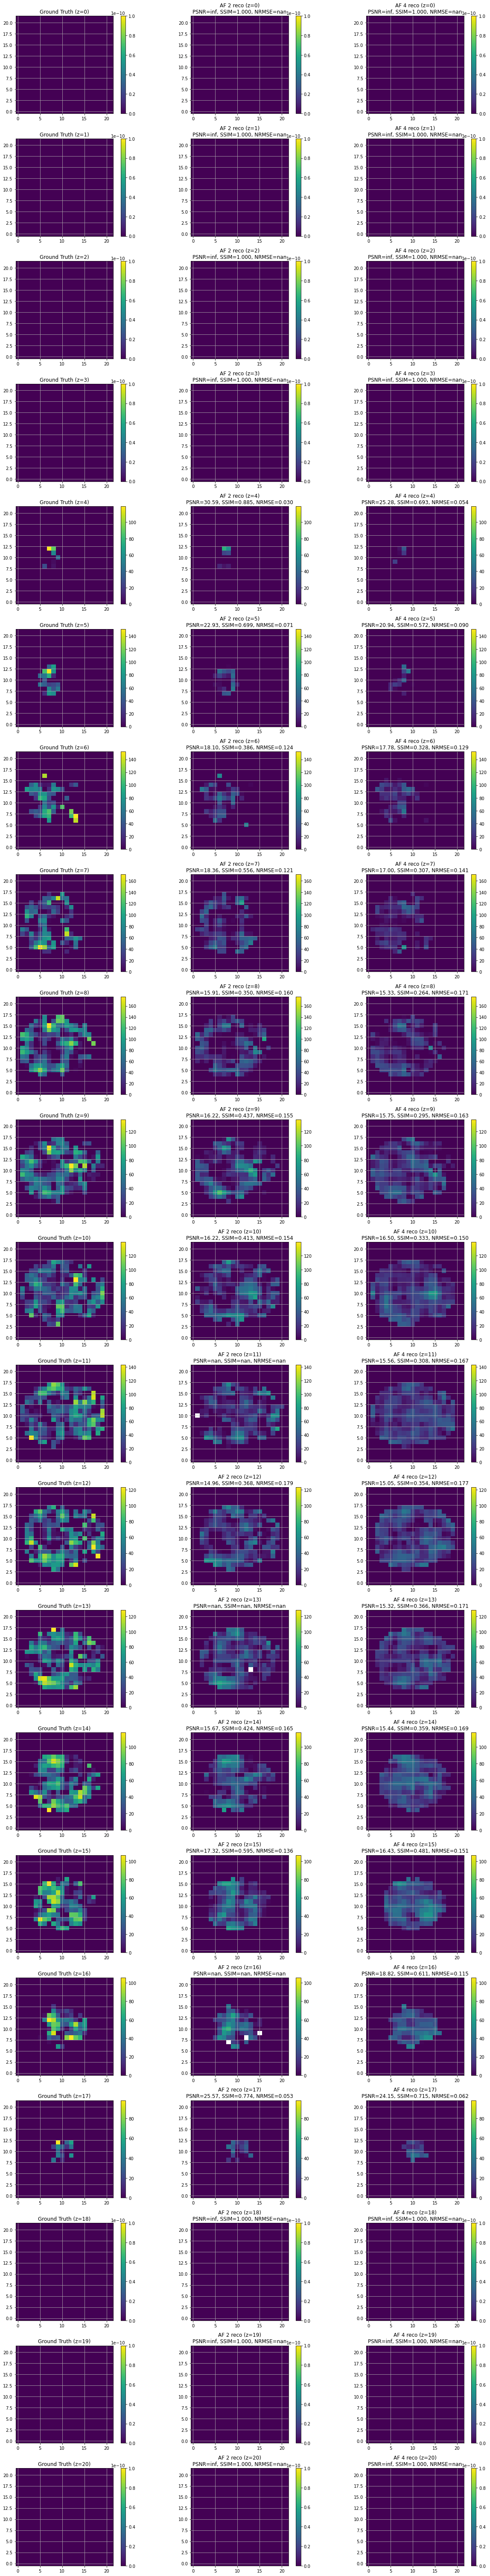

In [6]:
tf = 50 #50 = Water, 61 Glucose, 24 Glx
T = 0

comparison_Plot_3D_vs_Ifft(Water_AF2, Water_GT, Water_AF4, tf, T, domain="time", label = "AF 2 reco", label2 = "AF 4 reco", label3="Ground Truth", fixed_scale = True)

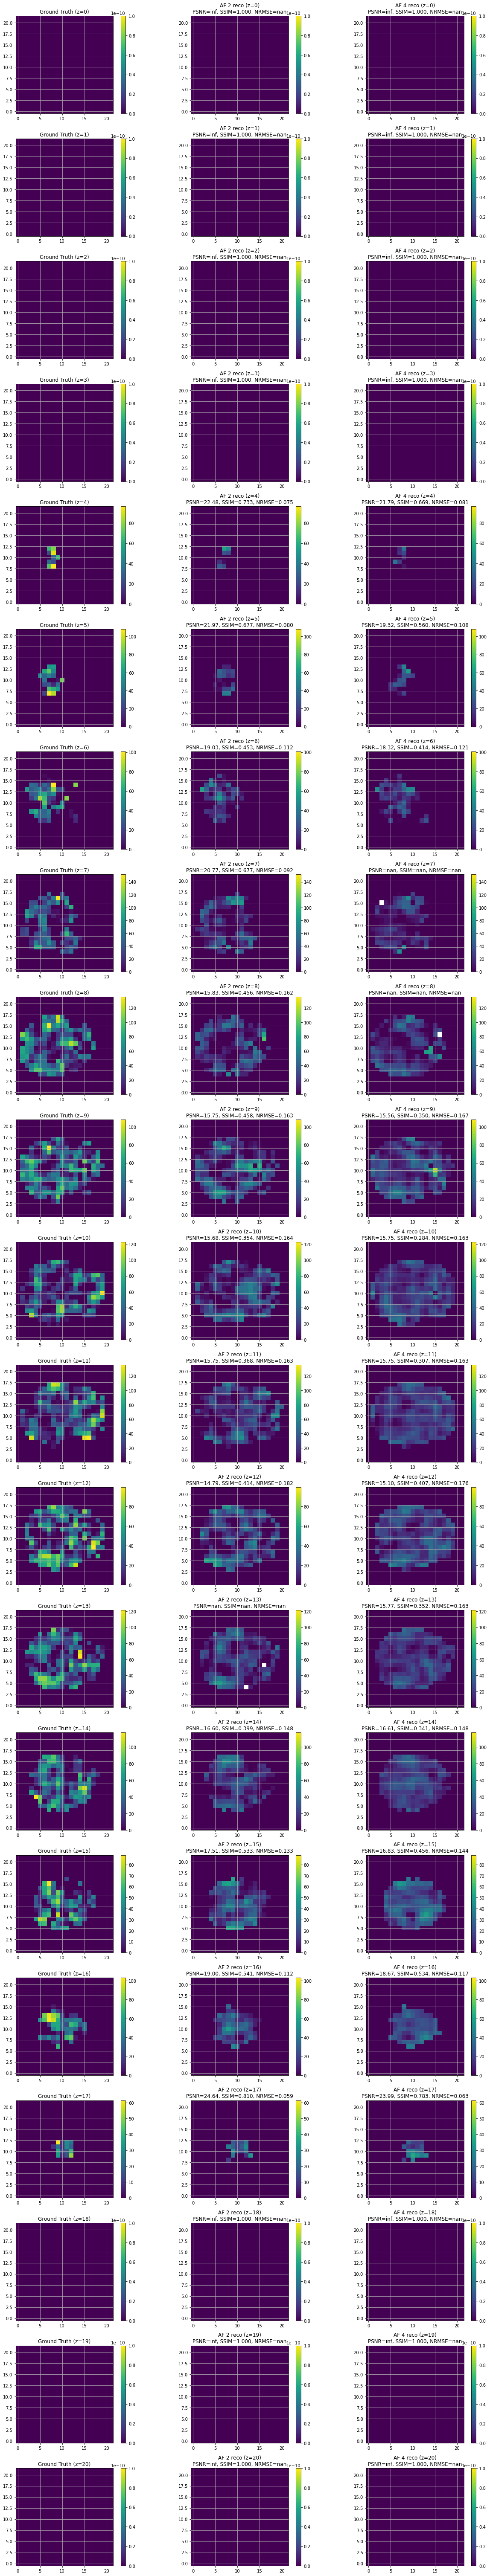

In [7]:
tf = 50 #50 = Water, 61 Glucose, 24 Glx
T = 1

comparison_Plot_3D_vs_Ifft(Water_AF2, Water_GT, Water_AF4, tf, T, domain="time", label = "AF 2 reco", label2 = "AF 4 reco", label3="Ground Truth", fixed_scale = True)

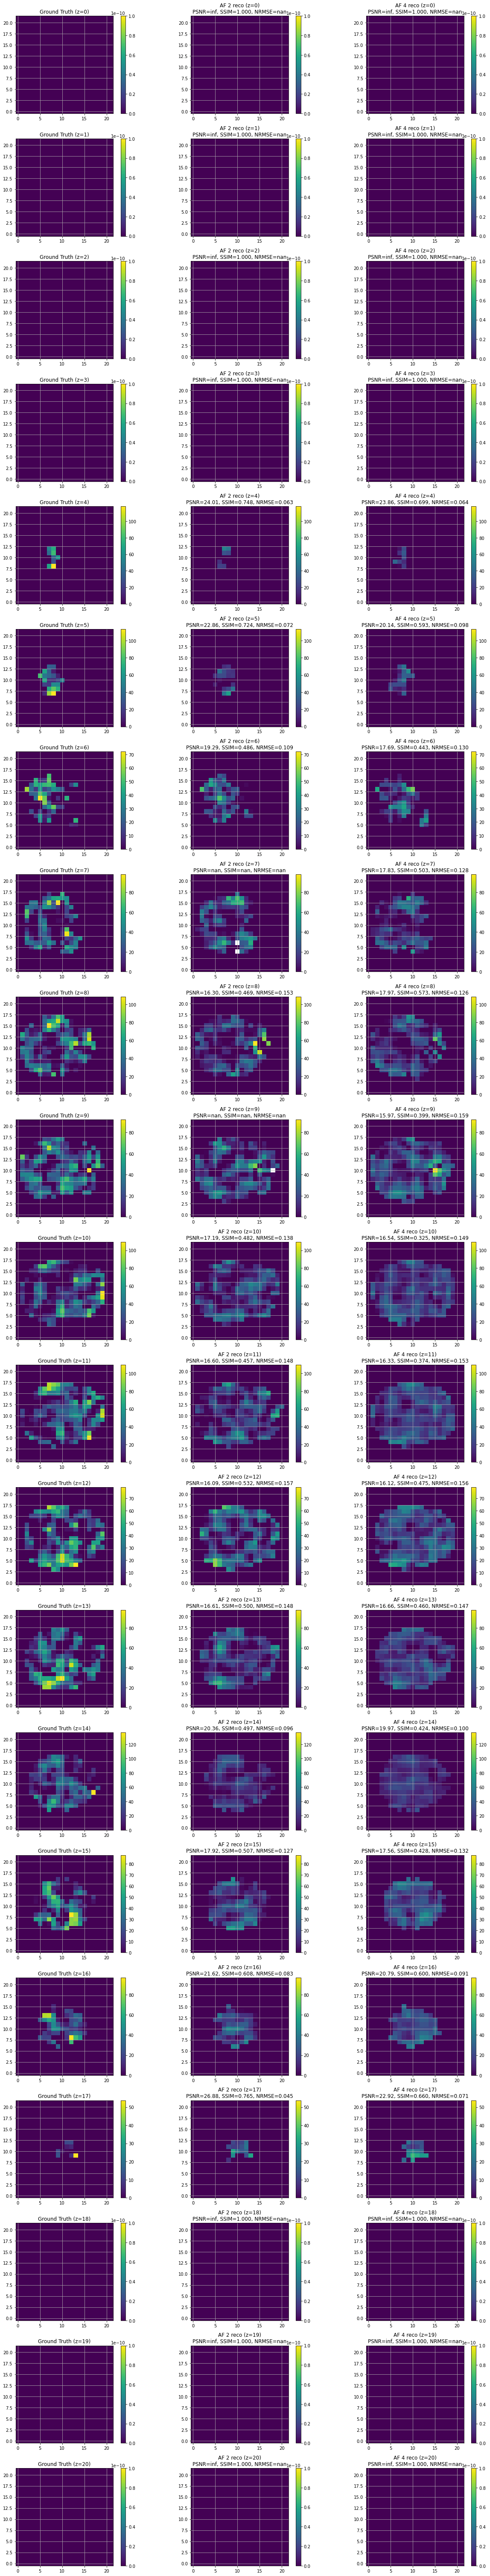

In [8]:
tf = 50 #50 = Water, 61 Glucose, 24 Glx
T = 2

comparison_Plot_3D_vs_Ifft(Water_AF2, Water_GT, Water_AF4, tf, T, domain="time", label = "AF 2 reco", label2 = "AF 4 reco", label3="Ground Truth", fixed_scale = True)

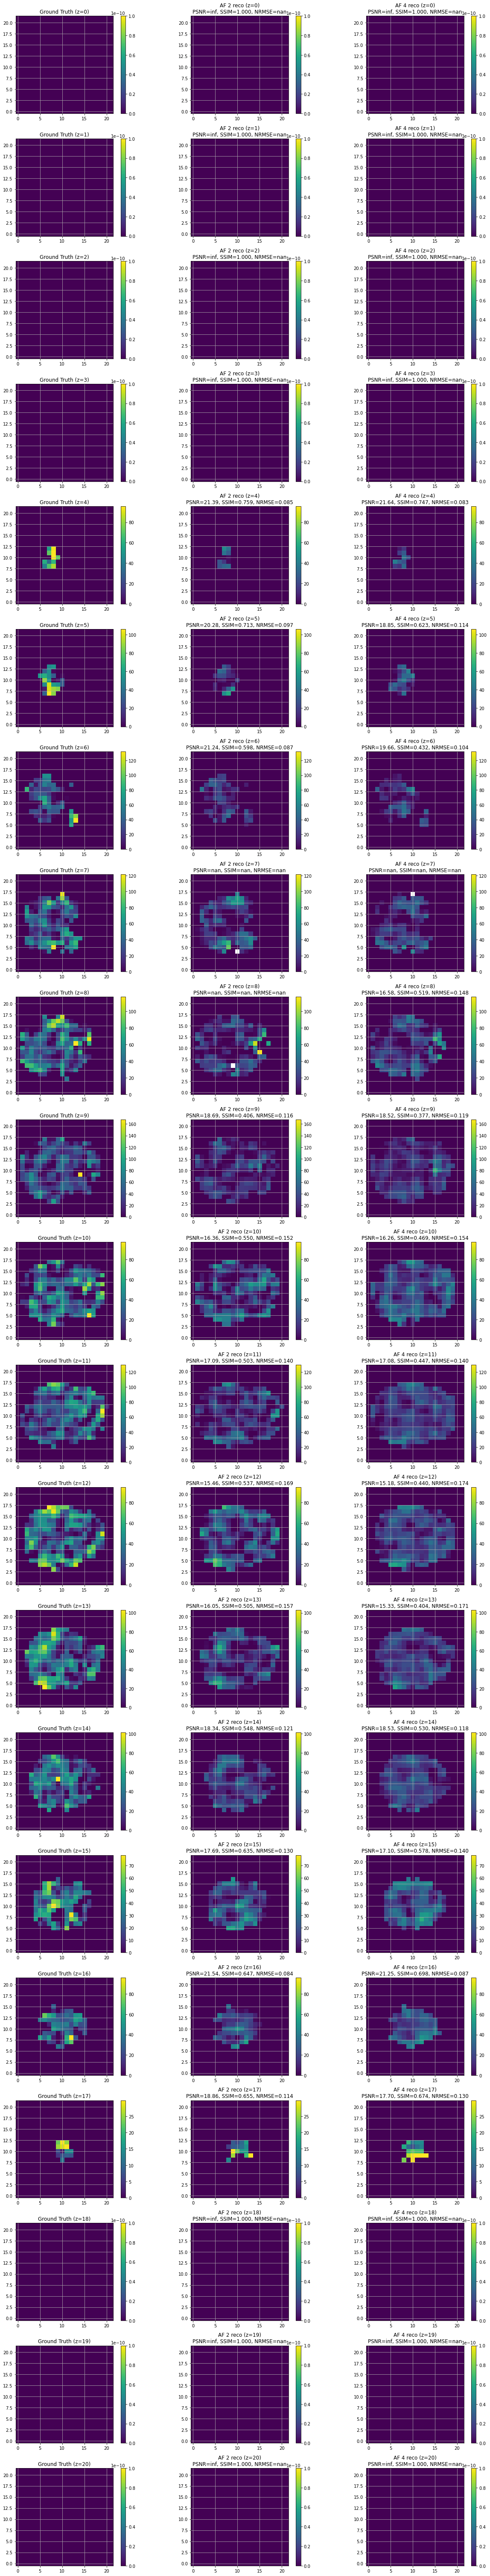

In [9]:
tf = 50 #50 = Water, 61 Glucose, 24 Glx
T = 3

comparison_Plot_3D_vs_Ifft(Water_AF2, Water_GT, Water_AF4, tf, T, domain="time", label = "AF 2 reco", label2 = "AF 4 reco", label3="Ground Truth", fixed_scale = True)

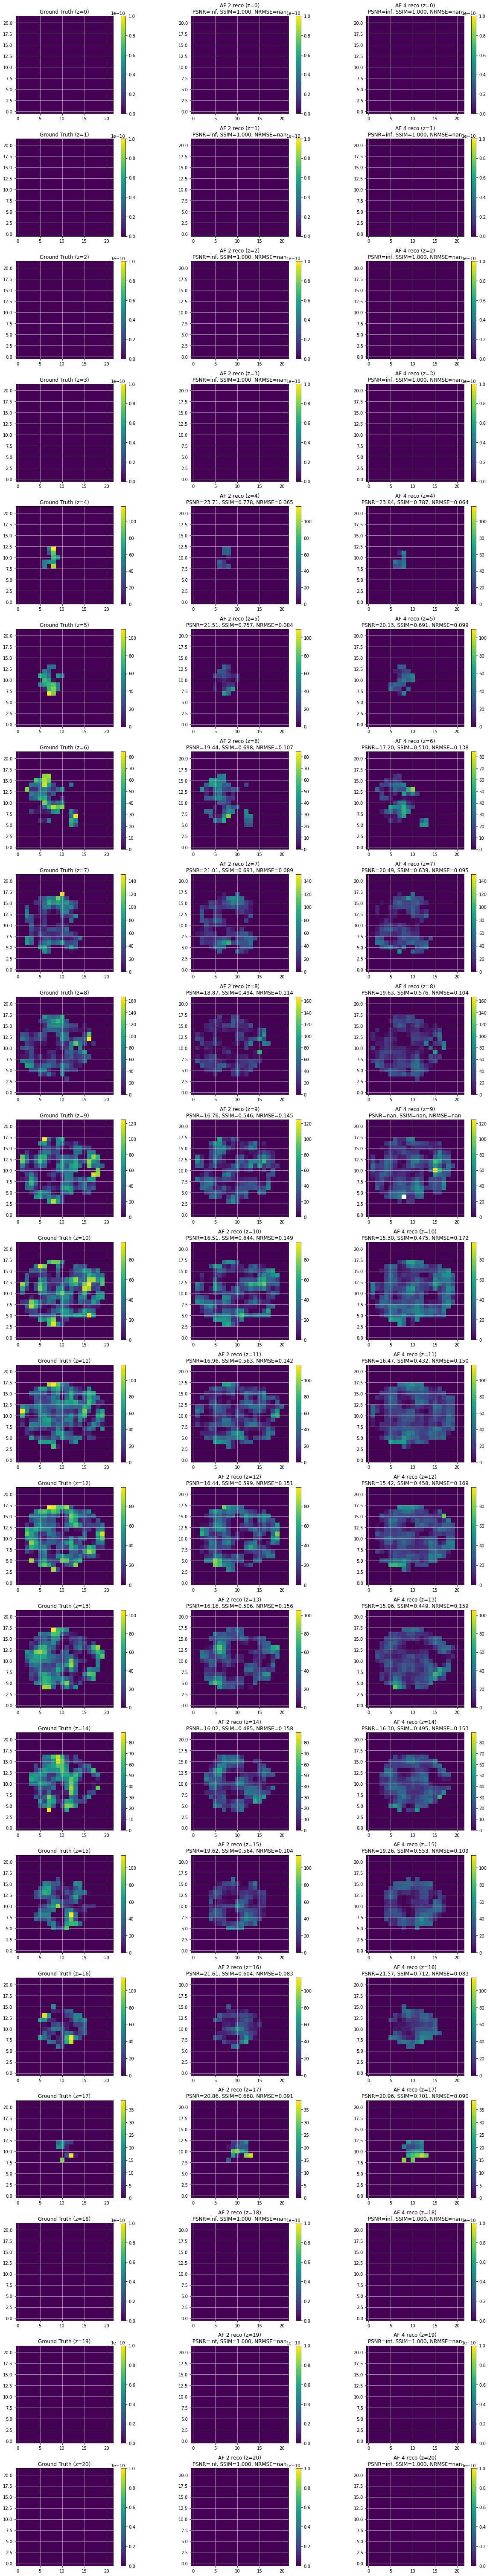

In [10]:
tf = 50 #50 = Water, 61 Glucose, 24 Glx
T = 4

comparison_Plot_3D_vs_Ifft(Water_AF2, Water_GT, Water_AF4, tf, T, domain="time", label = "AF 2 reco", label2 = "AF 4 reco", label3="Ground Truth", fixed_scale = True)

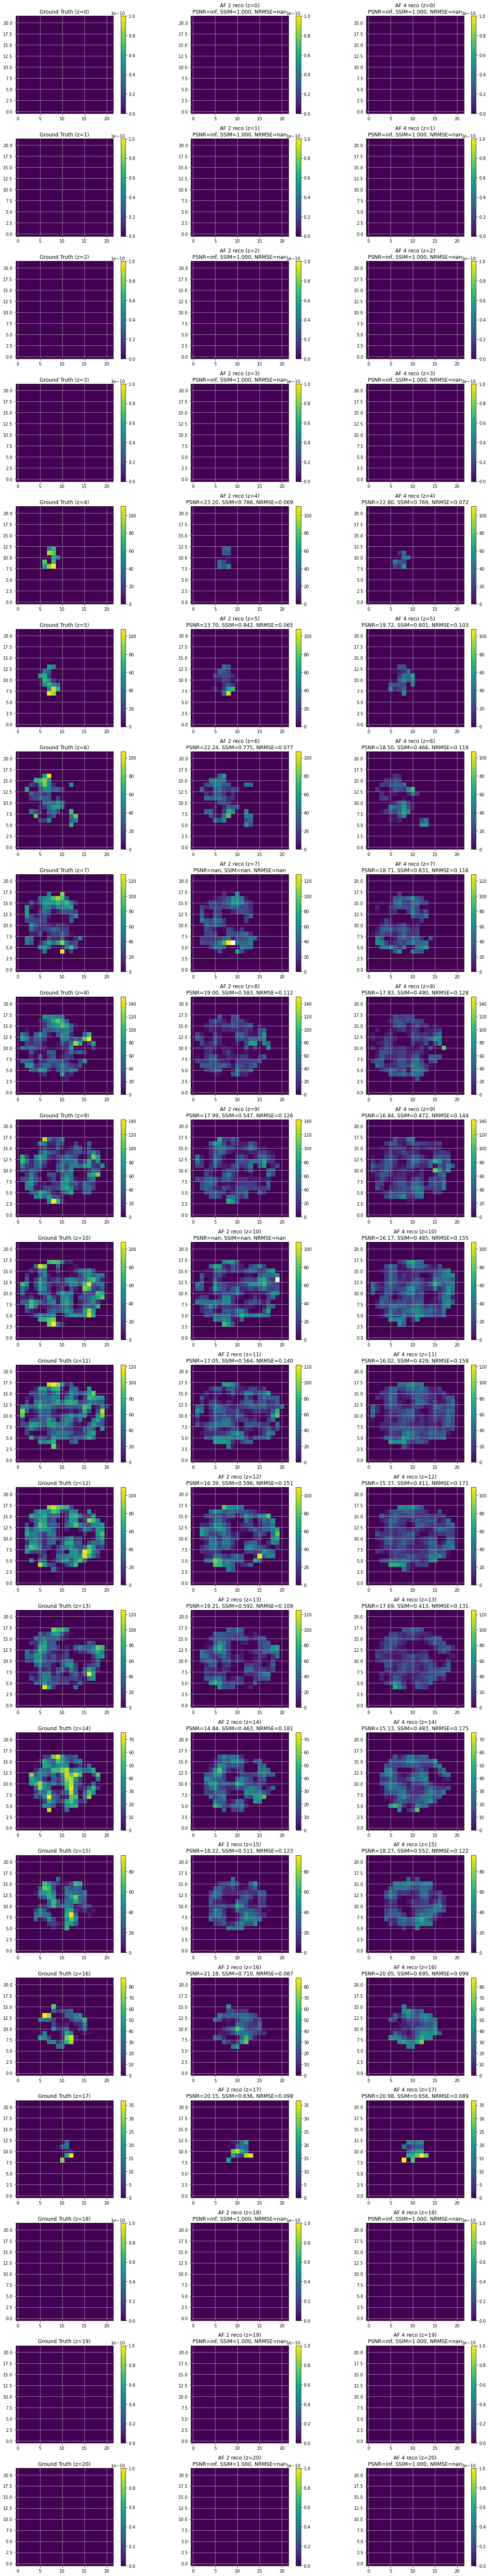

In [11]:
tf = 50 #50 = Water, 61 Glucose, 24 Glx
T = 5

comparison_Plot_3D_vs_Ifft(Water_AF2, Water_GT, Water_AF4, tf, T, domain="time", label = "AF 2 reco", label2 = "AF 4 reco", label3="Ground Truth", fixed_scale = True)

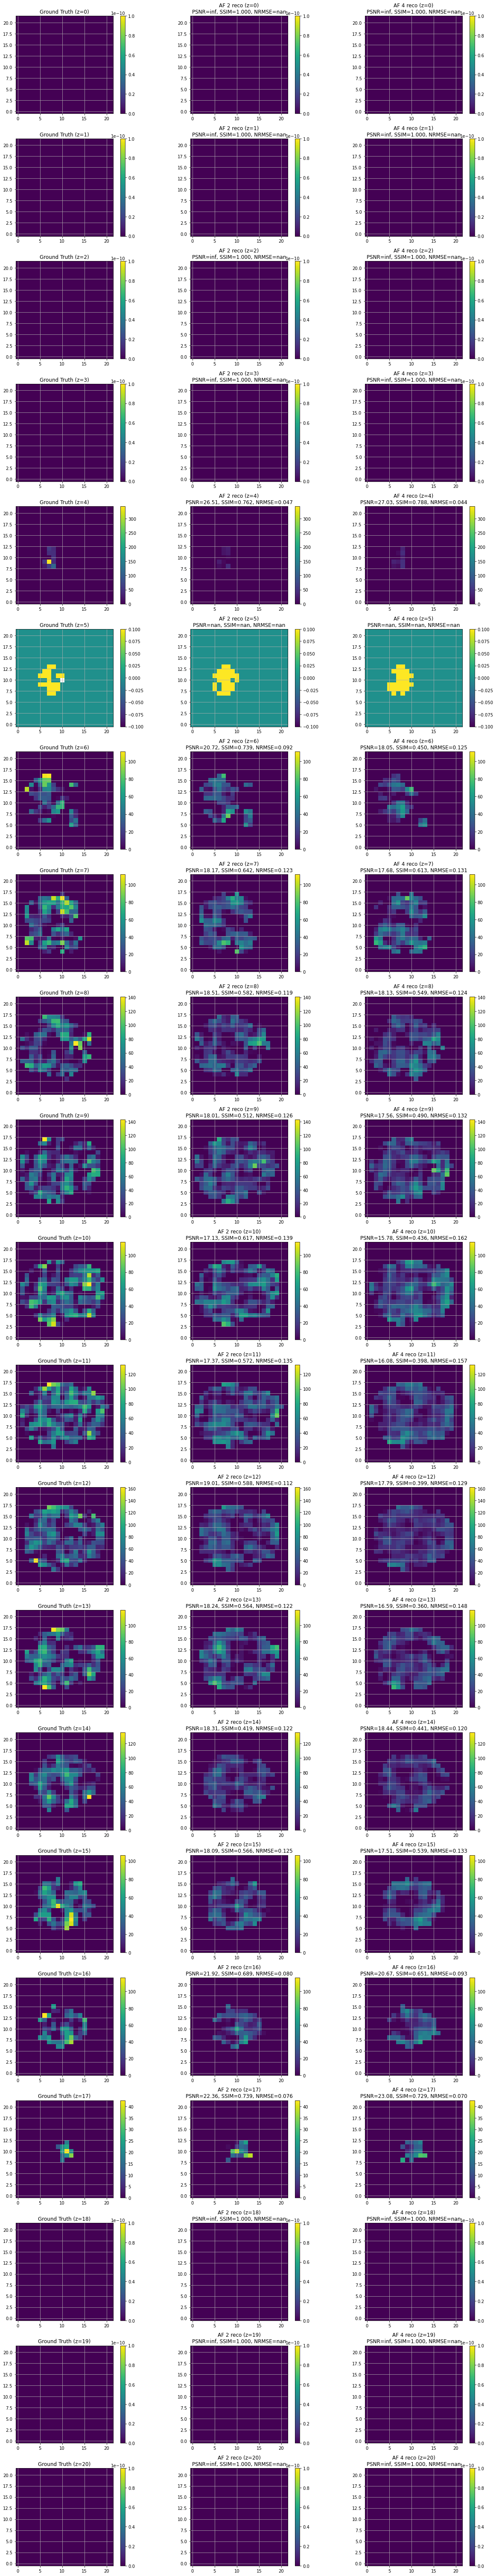

In [12]:
tf = 50 #50 = Water, 61 Glucose, 24 Glx
T = 6

comparison_Plot_3D_vs_Ifft(Water_AF2, Water_GT, Water_AF4, tf, T, domain="time", label = "AF 2 reco", label2 = "AF 4 reco", label3="Ground Truth", fixed_scale = True)

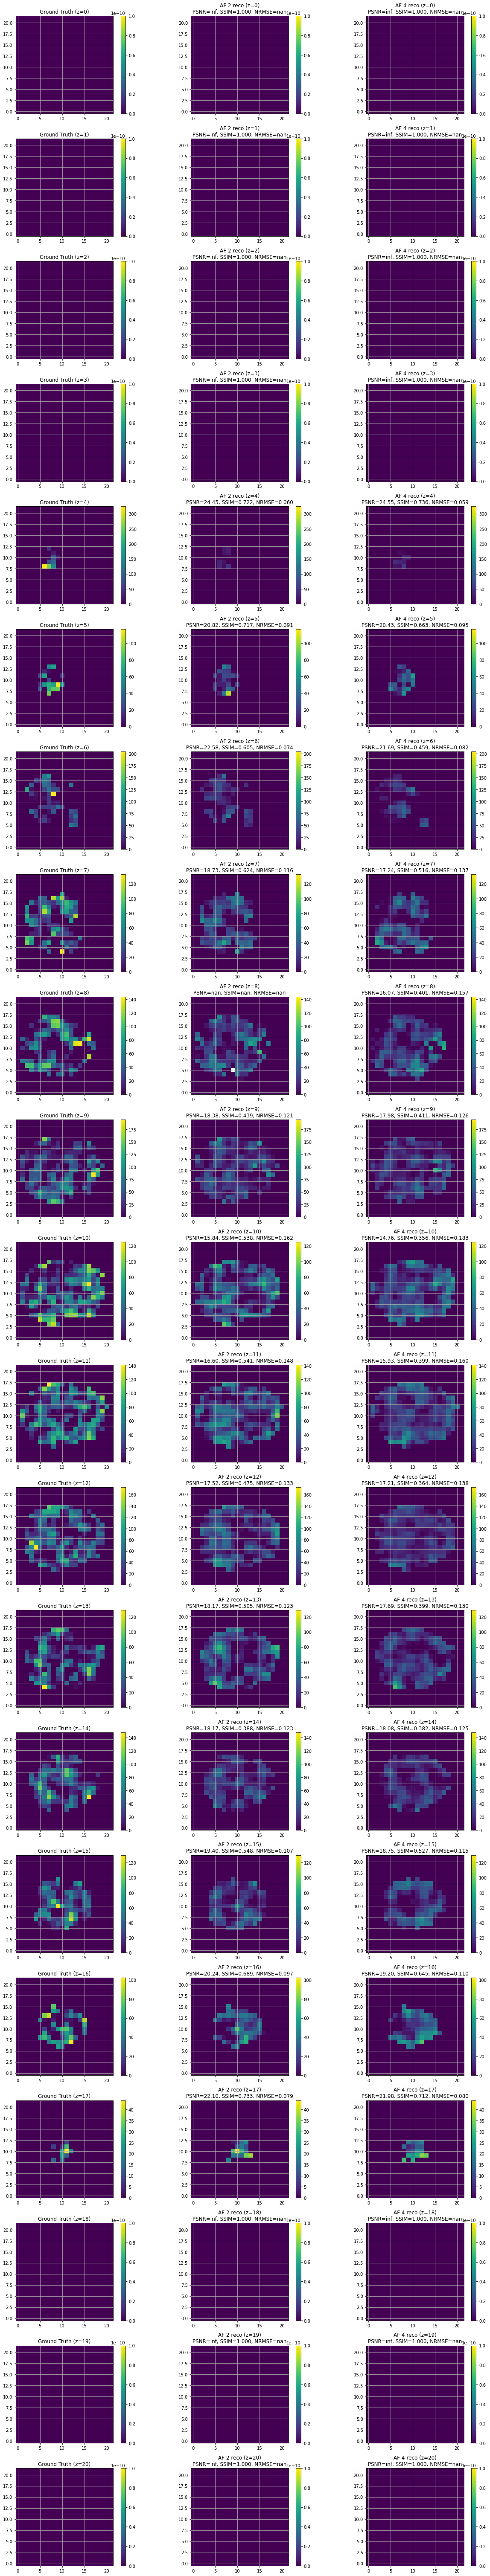

In [13]:
tf = 50 #50 = Water, 61 Glucose, 24 Glx
T = 7

comparison_Plot_3D_vs_Ifft(Water_AF2, Water_GT, Water_AF4, tf, T, domain="time", label = "AF 2 reco", label2 = "AF 4 reco", label3="Ground Truth", fixed_scale = True)